In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
# Building experiments configs

from experiments.configs import DATA_SOURCE_BY_ALIAS, DEFAULT_UNINFORMED_USERS_CONFIG
from experiments.experiment import Experiment
from user.informed_user import InformedUser

from fee_algorithm.fixed_fee import FixedFee
from fee_algorithm.discrete_fee_perfect_oracle import DiscreteFeePerfectOracle
# from fee_algorithm.continuous_fee_perfect_oracle import ContinuousFeePerfectOracle
# from fee_algorithm.fee_based_on_historical_price import FeeBasedOnHistoricalPrice
from fee_algorithm.based_on_trade_count_fee import BasedOnTradeCountFee
from fee_algorithm.adaptive_fee_based_on_block_price_move import AdaptiveBasedOnPreviousBlockPriceMoveFee

from copy import deepcopy

fee_algos_to_consider = {
    "fixed_fee": FixedFee(exchange_fee_rate=0.003), # 30 bps
    "based_on_trade_count_fee": BasedOnTradeCountFee(a_to_b_exchange_fee_rate=0.003, b_to_a_exchange_fee_rate=0.003), # 30 bps
    "adaptive_based_on_previous_block_price_move_fee": AdaptiveBasedOnPreviousBlockPriceMoveFee(a_to_b_exchange_fee_rate=0.003, b_to_a_exchange_fee_rate=0.003), # 30 bps
    "discrete_fee_perfect_oracle": DiscreteFeePerfectOracle(fee_rate_in_arbitrage_direction=0.0045, fee_rate_in_non_arbitrage_direction=0.0015), # 45/15 bps
    # "continuous_fee_perfect_oracle": ContinuousFeePerfectOracle(default_fee_rate=0.003), # 30 bps
    # "fee_based_on_historical_price": FeeBasedOnHistoricalPrice(alpha=0.3, fee_in_increasing_deviation_direction=0.0045, fee_in_decreasing_deviation_direction=0.0015), # 45/15 bps
}

experiment_configs = {}

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    data_source = DATA_SOURCE_BY_ALIAS[period_alias]
    for fee_algo_alias, fee_algo in fee_algos_to_consider.items():
        experiment_name = f"{period_alias}_{fee_algo_alias}"
        experiment_configs[experiment_name] = Experiment(
            data=data_source,
            fee_algorithm=deepcopy(fee_algo),
            uninformed_users=deepcopy(DEFAULT_UNINFORMED_USERS_CONFIG),
            informed_user=InformedUser(),
        )

In [3]:
from pprint import pprint

pprint(experiment_configs['volatile_market_fixed_fee'])

Experiment(data=ExperimentData(start_time=datetime.datetime(2022, 11, 10, 12, 0), end_time=datetime.datetime(2022, 11, 16, 12, 0), A_symbol='ETH', B_symbol='SHIB', stable_coin_symbol='USDT', candle_interval='5m'), fee_algorithm=FixedFee(exchange_fee_rate=0.003), informed_user=InformedUser(), uninformed_users=UninformedUsersConfig(uninformed_user=UninformedUser(mu=0.00016, sigma=1e-05), probability_of_trade=0.5, n_users=1), initial_pool_value=26263564, network_fee=5)


In [4]:
from experiments.run_experiment import run_experiment
from experiments.experiment import ExperimentResult
import numpy as np

experiment_results: dict[str, ExperimentResult] = {}


for experiment_name, experiment_config in experiment_configs.items():
    np.random.seed(0)
    experiment_results[experiment_name] = run_experiment(experiment_config)

/Users/ir.v.lebedeva/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


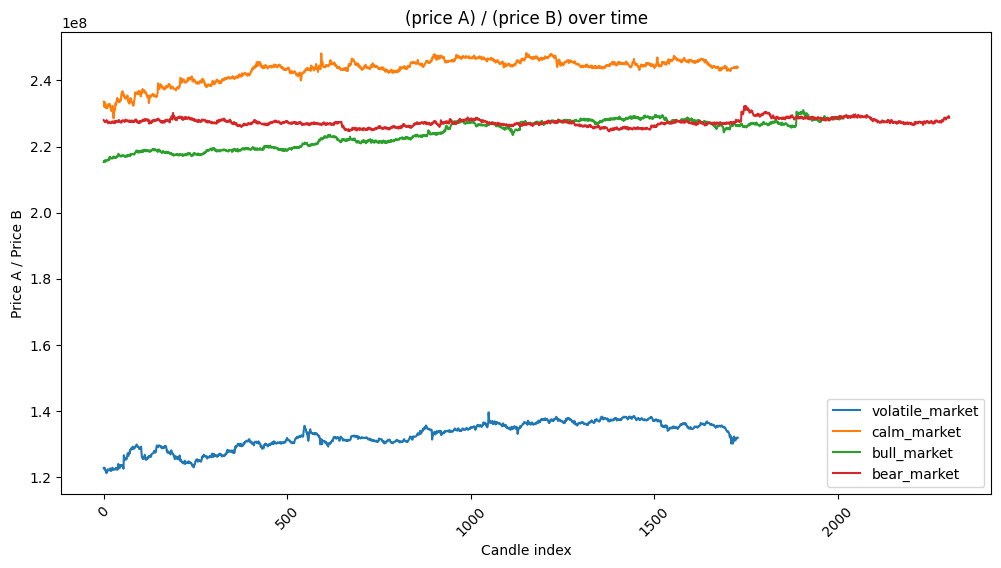

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_name = f"{period_alias}_fixed_fee"
    experiment_result = experiment_results[experiment_name]
    plt.plot(experiment_result.data["price_A"] / experiment_result.data["price_B"], label=period_alias)
    plt.title("(price A) / (price B) over time")

plt.ylabel("Price A / Price B")
plt.xlabel("Candle index")
# plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="lower right")

plt.show()

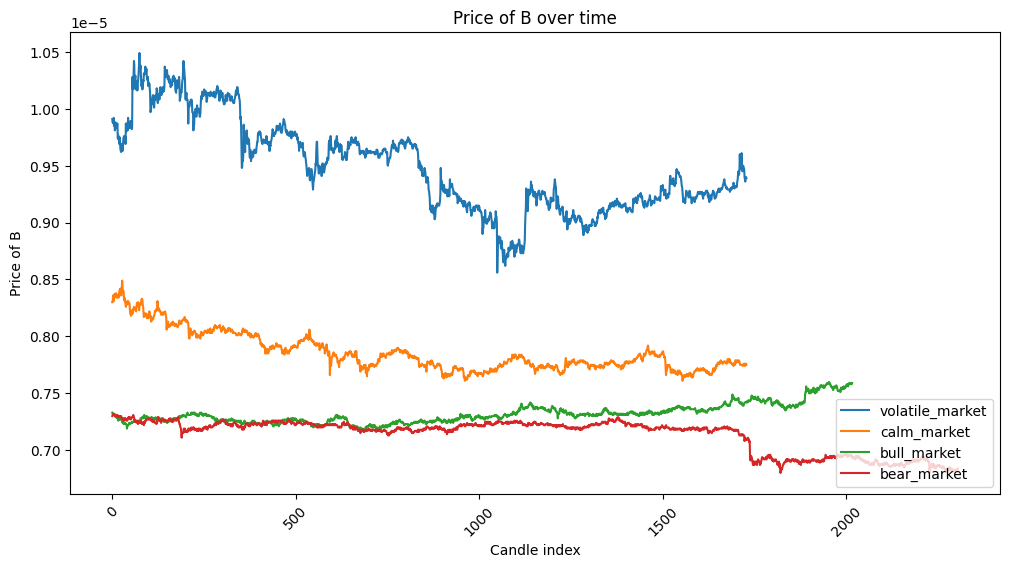

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_name = f"{period_alias}_fixed_fee"
    experiment_result = experiment_results[experiment_name]
    plt.plot(experiment_result.data["price_B"], label=period_alias)
    plt.title("Price of B over time")

plt.ylabel("Price of B")
plt.xlabel("Candle index")
# plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="lower right")

plt.show()

### Results

In [7]:
from visualizations.compare_fee_algoritms import plot_participants_markouts, plot_impermanent_loss, get_experiment_summary

In [8]:
def plot_results_for_period(period_alias: str, fee_algos_to_consider: list[str]):
    plot_participants_markouts(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )
    plot_impermanent_loss(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    summary = get_experiment_summary(
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    display(summary)

    return summary

### Results for bull market

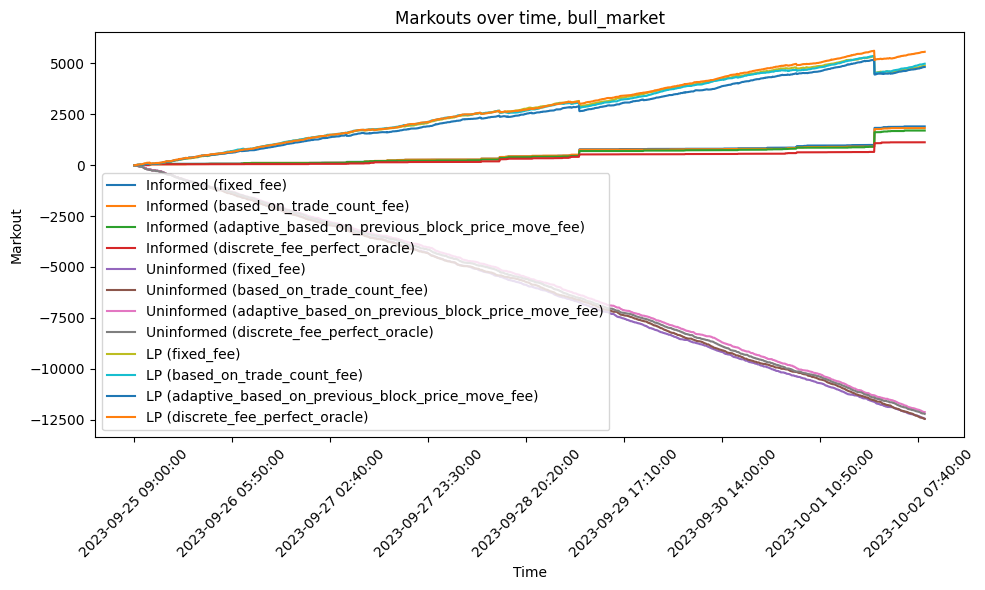

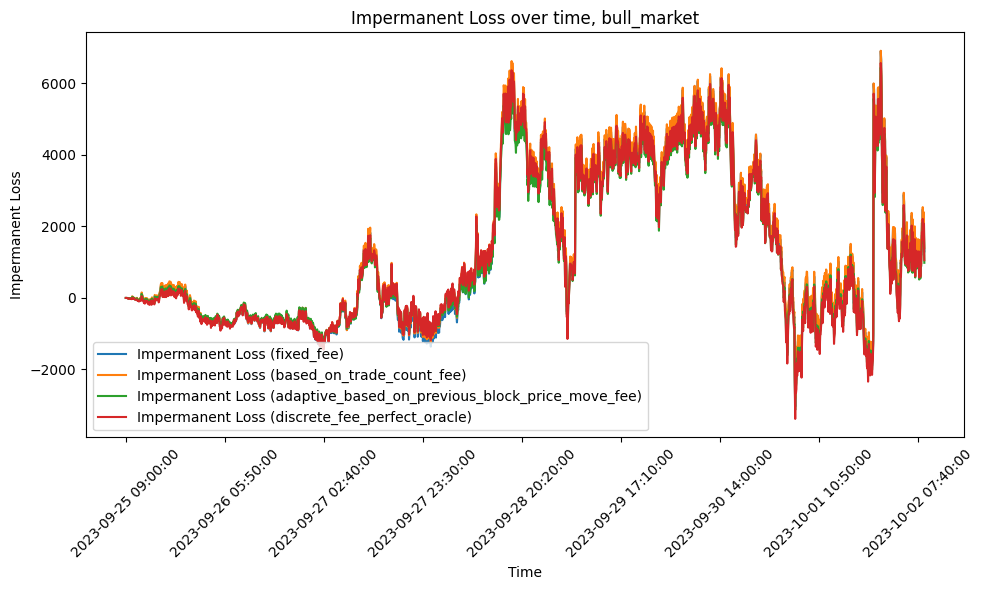

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,1906.93,-12458.28,4896.35,1303.37
1,based_on_trade_count_fee,1822.96,-12465.38,4987.42,1397.26
2,adaptive_based_on_previous_block_price_move_fee,1703.42,-12128.19,4824.77,983.94
3,discrete_fee_perfect_oracle,1126.51,-12219.97,5573.46,1056.40


In [11]:
bull_market_summary = plot_results_for_period("bull_market", list(fee_algos_to_consider.keys()))

### Results for calm market

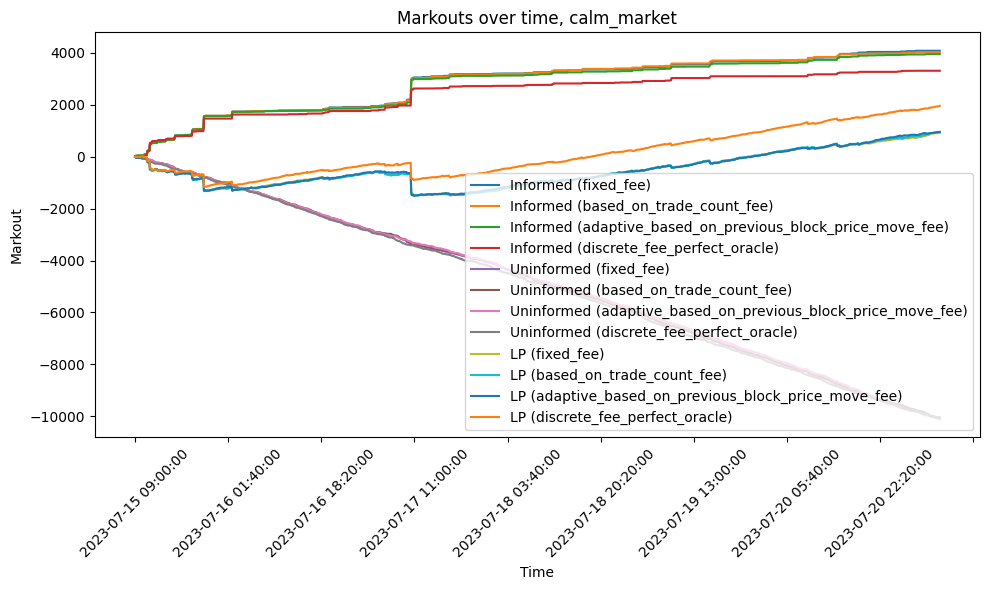

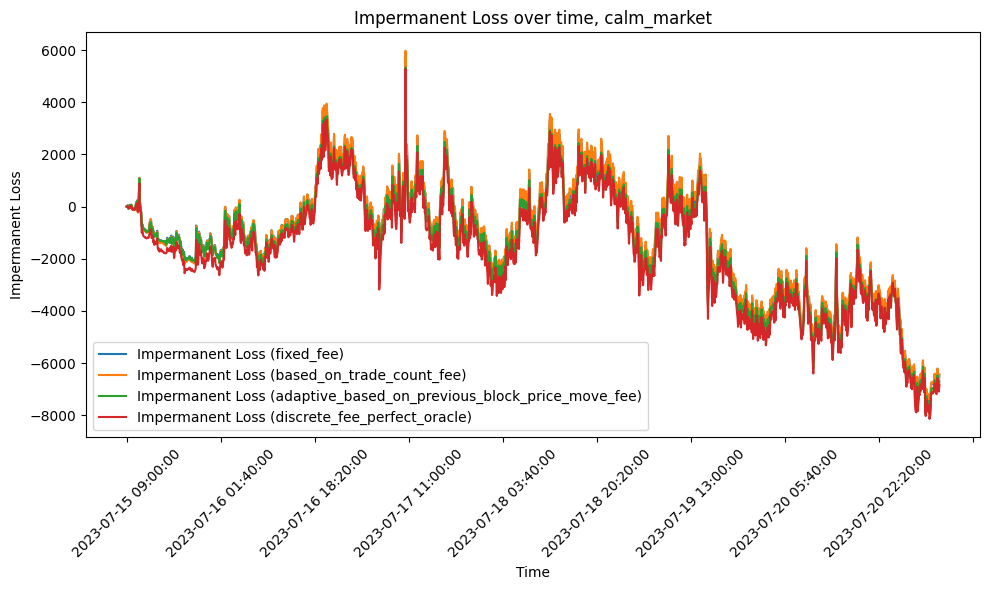

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,4084.05,-10084.40,925.36,-6453.66
1,based_on_trade_count_fee,4023.01,-10039.68,941.67,-6430.28
2,adaptive_based_on_previous_block_price_move_fee,3954.57,-10079.88,960.31,-6697.95
3,discrete_fee_perfect_oracle,3313.31,-10100.61,1957.30,-6831.78


In [12]:
calm_market_summary = plot_results_for_period("calm_market", list(fee_algos_to_consider.keys()))

### Results for bear market

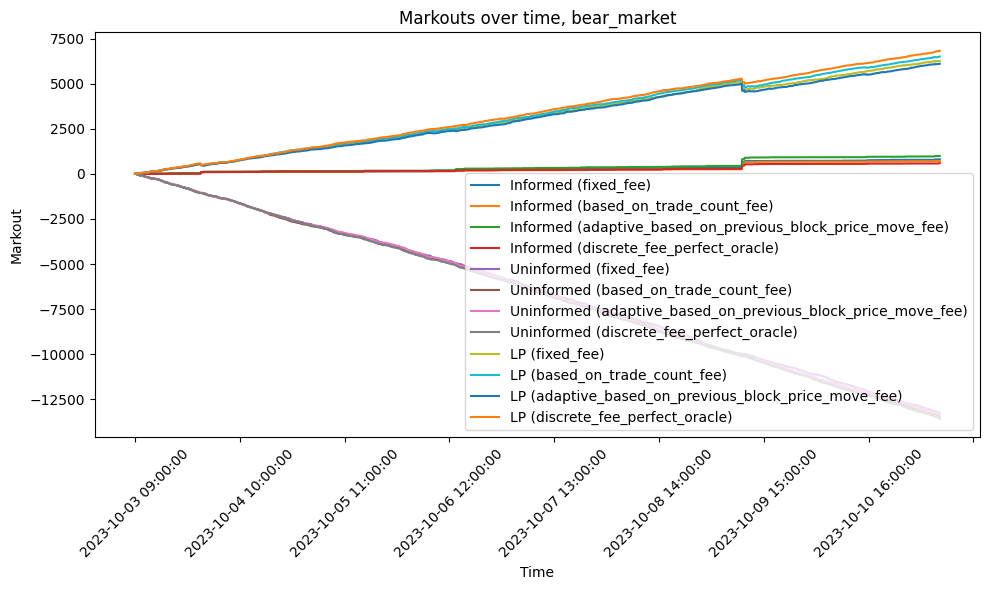

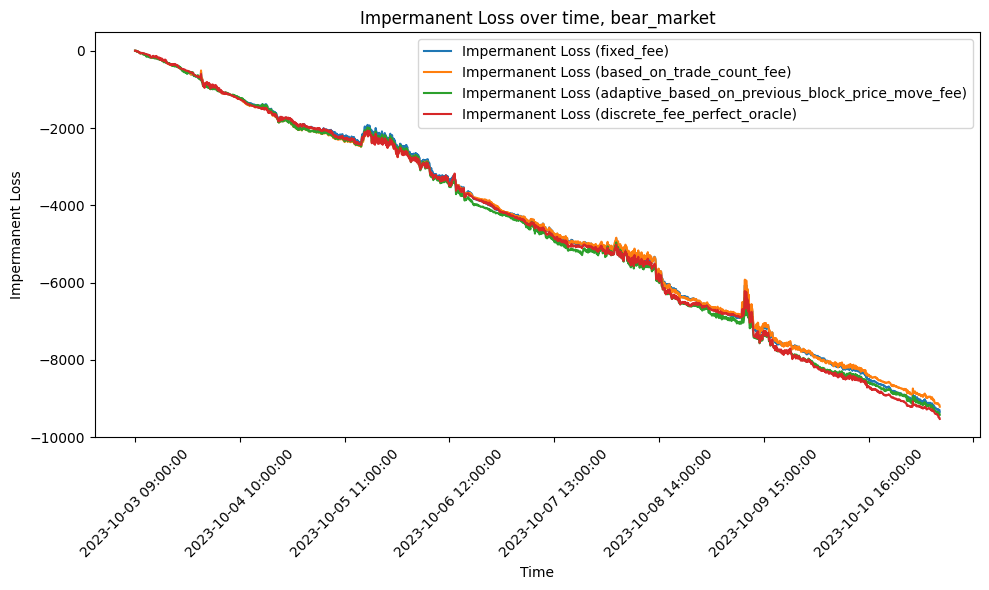

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,811.13,-13238.90,6267.77,-9344.18
1,based_on_trade_count_fee,718.78,-13453.82,6515.05,-9213.35
2,adaptive_based_on_previous_block_price_move_fee,996.19,-13340.29,6109.10,-9421.50
3,discrete_fee_perfect_oracle,596.59,-13586.57,6829.97,-9528.57


In [13]:
bear_market_summary = plot_results_for_period("bear_market", list(fee_algos_to_consider.keys()))

### Results for volatile market

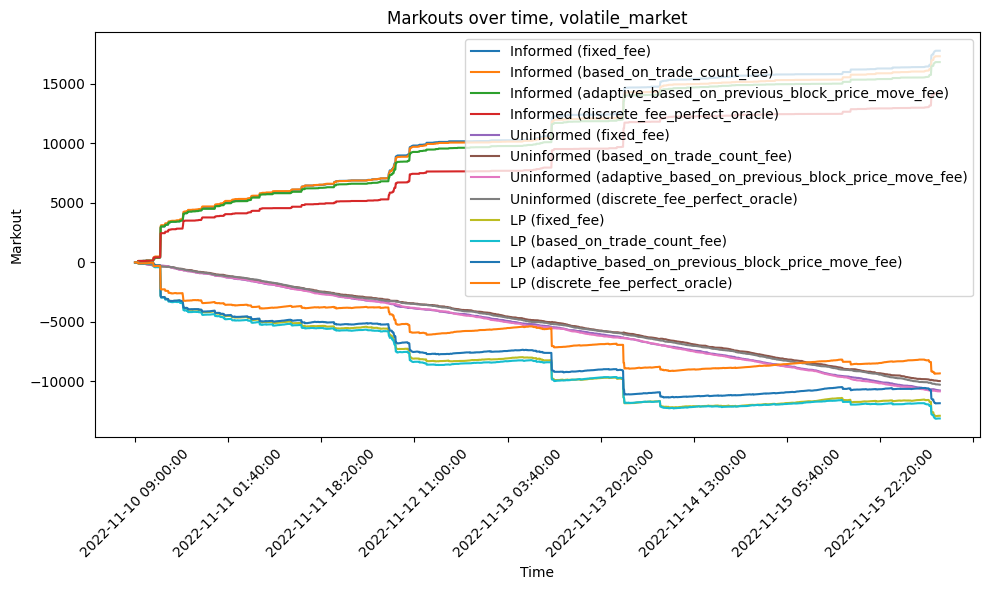

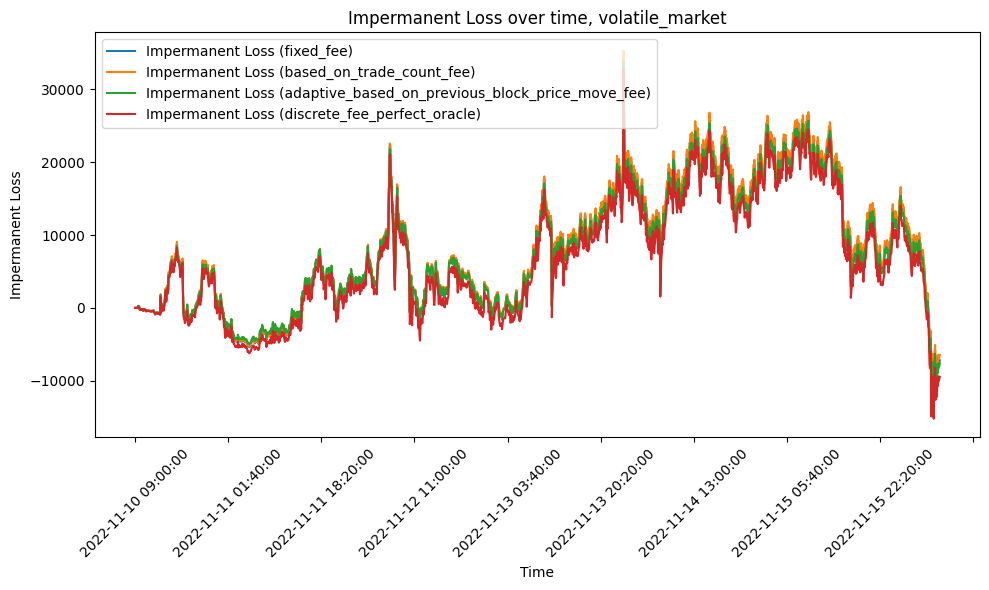

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,17776.03,-10761.15,-12889.88,-7191.03
1,based_on_trade_count_fee,17312.22,-9971.28,-13115.94,-6460.72
2,adaptive_based_on_previous_block_price_move_fee,16822.61,-10837.47,-11835.14,-7654.95
3,discrete_fee_perfect_oracle,14217.41,-10279.02,-9328.40,-9461.08


In [14]:
volatile_market_summary = plot_results_for_period("volatile_market", list(fee_algos_to_consider.keys()))

### All results

In [15]:
import pandas as pd

bull_market_summary["period_alias"] = "bull"
calm_market_summary["period_alias"] = "calm"
bear_market_summary["period_alias"] = "bear"
volatile_market_summary["period_alias"] = "volatile"

combined_df = pd.concat([volatile_market_summary, calm_market_summary, bull_market_summary, bear_market_summary], ignore_index=True)

combined_df = combined_df.set_index(['period_alias'])

display(combined_df)

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
period_alias,,,,,
volatile,fixed_fee,17776.03,-10761.15,-12889.88,-7191.03
volatile,based_on_trade_count_fee,17312.22,-9971.28,-13115.94,-6460.72
volatile,adaptive_based_on_previous_block_price_move_fee,16822.61,-10837.47,-11835.14,-7654.95
volatile,discrete_fee_perfect_oracle,14217.41,-10279.02,-9328.40,-9461.08
calm,fixed_fee,4084.05,-10084.40,925.36,-6453.66
calm,based_on_trade_count_fee,4023.01,-10039.68,941.67,-6430.28
calm,adaptive_based_on_previous_block_price_move_fee,3954.57,-10079.88,960.31,-6697.95
calm,discrete_fee_perfect_oracle,3313.31,-10100.61,1957.30,-6831.78
bull,fixed_fee,1906.93,-12458.28,4896.35,1303.37


In [16]:
### Just more readable visualization of same df

# Round the DataFrame to 2 decimal places
df = combined_df.reset_index().round(2)  # Ensure the index levels are retained as columns

# Styling function for alternating background colors and bold text
def highlight_periods(row):
    unique_periods = df['period_alias'].unique()  # Access the 'period_alias' column
    colors = [
        'background-color: #f2f2f2;',  # Light gray
        'background-color: #d9eaf7;',  # Pastel blue
        'background-color: #eaf7d9;',  # Pastel green
        'background-color: #fff6cc;',  # Pastel yellow
    ]
    group_index = list(unique_periods).index(row['period_alias'])
    return [colors[group_index % len(colors)]] * len(row)

def make_numbers_bold(val):
    """Make all numeric values bold."""
    if isinstance(val, (int, float, str)):
        return 'font-weight: bold; color: #000;'
    return ''  # No styling for non-numeric values

# Format numbers to 2 decimal places
def format_numbers(val):
    """Ensure all numeric values are formatted to 2 decimal places."""
    if isinstance(val, (int, float)):
        return f'{val:.2f}'
    return val

# Apply alternating background colors, bold styling, and number formatting
styled_df = (
    df.style
    .apply(highlight_periods, axis=1)
    .applymap(make_numbers_bold)
    .format(format_numbers)  # Apply number formatting
)

styled_df

/var/folders/48/7_jn2w696tq1pr_p7zr8krnc0000gq/T/ipykernel_29138/1815749587.py:33: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  df.style


,period_alias,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,volatile,fixed_fee,17776.03,-10761.15,-12889.88,-7191.03
1,volatile,based_on_trade_count_fee,17312.22,-9971.28,-13115.94,-6460.72
2,volatile,adaptive_based_on_previous_block_price_move_fee,16822.61,-10837.47,-11835.14,-7654.95
3,volatile,discrete_fee_perfect_oracle,14217.41,-10279.02,-9328.40,-9461.08
4,calm,fixed_fee,4084.05,-10084.40,925.36,-6453.66
5,calm,based_on_trade_count_fee,4023.01,-10039.68,941.67,-6430.28
6,calm,adaptive_based_on_previous_block_price_move_fee,3954.57,-10079.88,960.31,-6697.95
7,calm,discrete_fee_perfect_oracle,3313.31,-10100.61,1957.30,-6831.78
8,bull,fixed_fee,1906.93,-12458.28,4896.35,1303.37
9,bull,based_on_trade_count_fee,1822.96,-12465.38,4987.42,1397.26


### Fee based on trade count state

In [17]:
from experiments.experiment import ExperimentResult
from utility import fix_x_axis_labels
from typing import Optional
from pool.liquidity_state import PoolLiquidityState

def plot_fee_based_on_trade_count_fee_history(experiment_result: ExperimentResult, fee_algo_name: str, first_updates: Optional[int] = None):
    all_snapshots = experiment_result.simulation_result.snapshots
    if first_updates is not None:
        all_snapshots = all_snapshots[:first_updates]

    a_to_b_fees = []
    b_to_a_fees = []
    
    
    for snapshot in all_snapshots:
        a_to_b_fees.append(snapshot.pool.fee_algorithm.a_to_b_exchange_fee_rate)
        b_to_a_fees.append(snapshot.pool.fee_algorithm.b_to_a_exchange_fee_rate)

    all_timestamps = experiment_result.simulation_result.timestamps
    if first_updates is not None:
        all_timestamps = all_timestamps[:first_updates]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(all_timestamps, a_to_b_fees, label="A to B exchange fee rate")
    ax.plot(all_timestamps, b_to_a_fees, label="B to A exchange fee rate")
    ax.set_xlabel("Time")
    ax.set_ylabel("Exchange fee rate")
    ax.legend(loc="upper right")
    plt.title(f"Exchange fee rate over time for {fee_algo_name} algorithm")

    fix_x_axis_labels(ax)

    plt.xticks(rotation=45)

    plt.show()

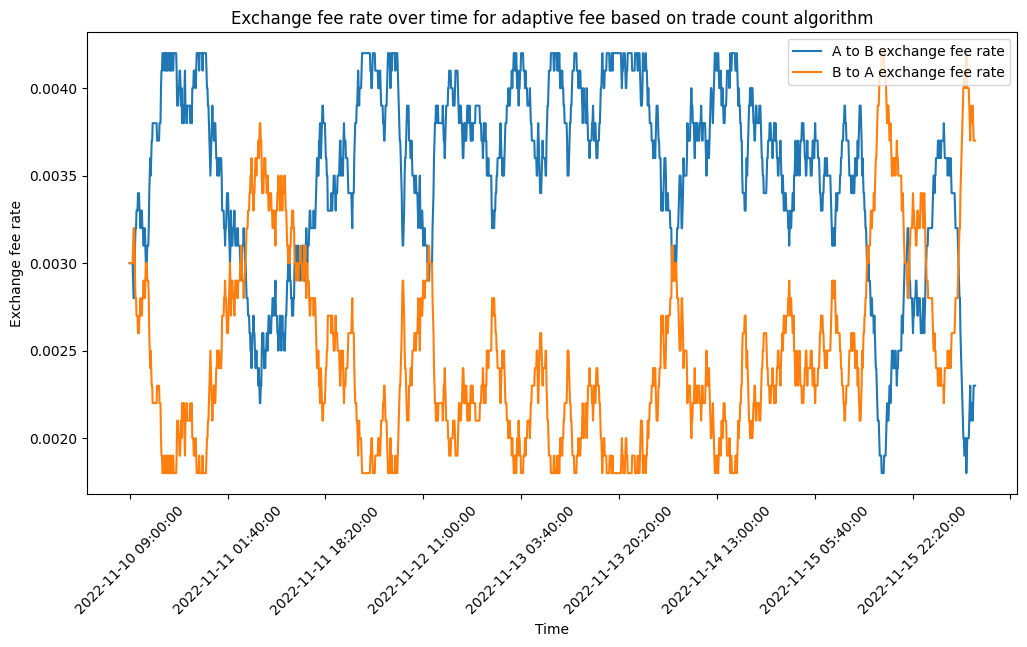

In [18]:
plot_fee_based_on_trade_count_fee_history(
    experiment_results["volatile_market_based_on_trade_count_fee"], 
    "adaptive fee based on trade count"
)

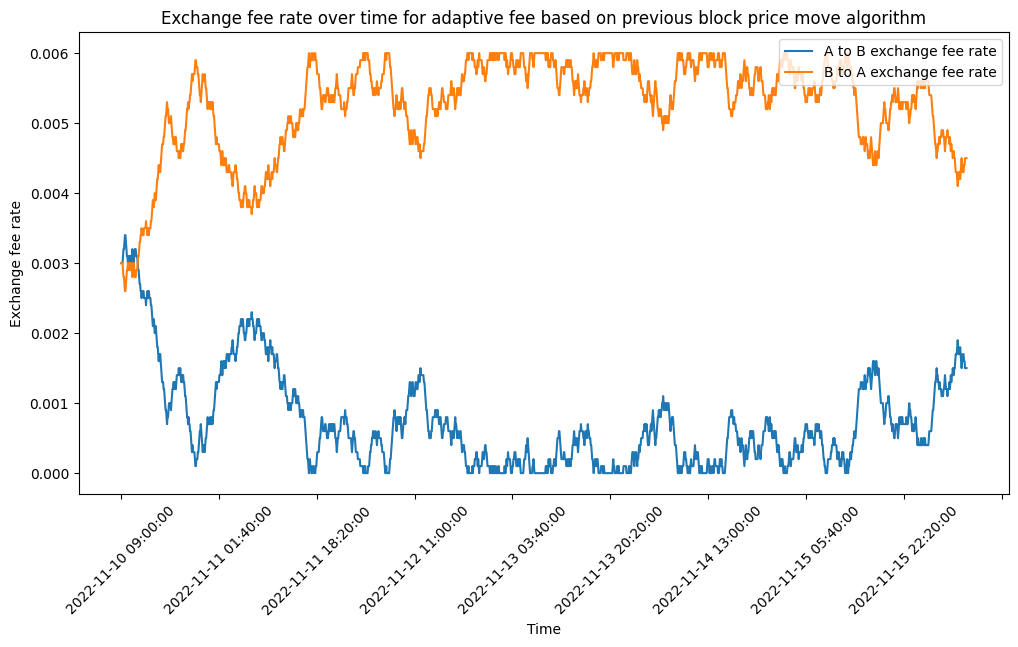

In [17]:
plot_fee_based_on_trade_count_fee_history(
    experiment_results["volatile_market_adaptive_based_on_previous_block_price_move_fee"], 
    "adaptive fee based on previous block price move",
)

### Fee based on price ema state

In [18]:
from experiments.experiment import ExperimentResult
from utility import fix_x_axis_labels
from typing import Optional

def plot_fee_algo_price_ema_vs_price(experiment_result: ExperimentResult, first_updates: Optional[int] = None):
    all_snapshots = experiment_result.simulation_result.snapshots
    if first_updates is not None:
        all_snapshots = all_snapshots[:first_updates]

    fee_algo_price_ema = []
    for snapshot in all_snapshots:
        fee_algo_price_ema.append(snapshot.pool.fee_algorithm.a_to_b_price_ema.average())
    
    real_prices = []
    for snapshot in all_snapshots:
        real_prices.append(snapshot.pool.get_a_to_b_exchange_price())
    

    all_timestamps = experiment_result.simulation_result.timestamps
    if first_updates is not None:
        all_timestamps = all_timestamps[:first_updates]

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(all_timestamps, fee_algo_price_ema, label="EMA of price from fee algorithm")
    ax.plot(all_timestamps, real_prices, label="Real price")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price")
    ax.legend(loc="upper right")
    plt.title("EMA of price from fee algorithm vs real price")

    fix_x_axis_labels(ax)

    plt.xticks(rotation=45)

    plt.show()

In [19]:
# plot_fee_algo_price_ema_vs_price(
#     experiment_results["volatile_market_fee_based_on_historical_price"], first_updates=100
# )